In [1]:
import os
import sys
import glob
import tqdm
import math
import librosa
import librosa.display as display
import pickle

import numpy as np
np.random.seed(42)
import pandas as pd

import IPython.display as i_disn
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split


In [2]:
with open(r"X_train_features.pkl","rb") as file:
    X_train_features = pickle.load(file)
    
with open(r"X_test_features.pkl","rb") as file:
    X_test_features = pickle.load(file)
    
with open(r"X_val_features.pkl","rb") as file:
    X_val_features = pickle.load(file)

with open(r"y_train.pkl","rb") as file:
    y_train = pickle.load(file)

with open(r"y_test.pkl","rb") as file:
    y_test = pickle.load(file)

with open(r"y_val.pkl","rb") as file:
    y_val = pickle.load(file)

In [3]:
print("Shape of training data: ", X_train_features.shape)
print("Shape of test data: ", X_test_features.shape)
print("Shape of validation data: ", X_val_features.shape)

Shape of training data:  (22840, 257, 69, 1)
Shape of test data:  (2820, 257, 69, 1)
Shape of validation data:  (2538, 257, 69, 1)


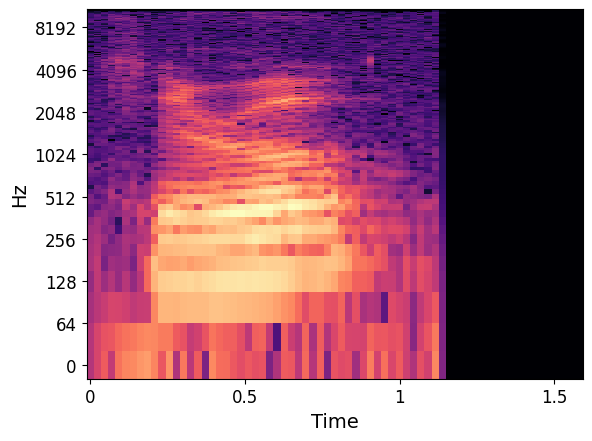

In [4]:
librosa.display.specshow(X_val_features[0].reshape(257, 69), x_axis='time', y_axis='log')

## VAE with MLP

In [4]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2

from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution

disable_eager_execution()
# enable_eager_execution()

In [5]:
def MinMaxScaler(features):
    scaled = []
    min_max_values = []
    for f in features:
        min_val = np.min(f)
        max_val = np.max(f)
        f_normalized = (f - min_val) / (max_val - min_val)
        min_max_values.append((min_val,max_val))
        scaled.append(f_normalized)
    return np.array(scaled),np.array(min_max_values)

In [6]:
X_train_features, X_train_min_max  = MinMaxScaler(X_train_features)
X_val_features , X_val_min_max = MinMaxScaler(X_val_features)
X_test_features , X_test_min_max = MinMaxScaler(X_test_features)

In [7]:
print("Shape of training data: ", X_train_features.shape)
print("Shape of test data: ", X_test_features.shape)
print("Shape of validation data: ", X_val_features.shape)

Shape of training data:  (22840, 257, 69, 1)
Shape of test data:  (2820, 257, 69, 1)
Shape of validation data:  (2538, 257, 69, 1)


In [70]:
X_train =  X_train_features.reshape(len(X_train_features),np.prod(X_train_features.shape[1:]))
X_test = X_test_features.reshape(len(X_test_features),np.prod(X_test_features.shape[1:]))
X_val = X_val_features.reshape(len(X_val_features),np.prod(X_val_features.shape[1:]))

In [71]:
print("Shape of training data: ", X_train.shape)
print("Shape of test data: ", X_test.shape)
print("Shape of validation data: ", X_val.shape)

Shape of training data:  (22840, 17733)
Shape of test data:  (2820, 17733)
Shape of validation data:  (2538, 17733)


In [10]:

original_dim = X_train.shape[1]
latent_dim = 2  # Size of the latent space



In [12]:
# Encoder network
inputs = Input(shape=(X_train.shape[1],))

x = Dense(1024, activation='relu')(inputs)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


def sampling(args):
    z_mean, z_log_var = args
    batch_size = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder network
decoder_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_inputs)
x = Dense(512, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(17733, activation='sigmoid')(x)

# Define the encoder and decoder models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_inputs, outputs, name='decoder')


In [13]:
# see encoder summary
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 17733)]              0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 1024)                 1815961   ['input_2[0][0]']             
                                                          6                                       
                                                                                                  
 dense_8 (Dense)             (None, 512)                  524800    ['dense_7[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 256)                  131328    ['dense_8[0][0]']       

In [14]:
# see decoder summary
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_10 (Dense)            (None, 256)               768       
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 dense_12 (Dense)            (None, 1024)              525312    
                                                                 
 dense_13 (Dense)            (None, 17733)             18176325  
                                                                 
Total params: 18833989 (71.85 MB)
Trainable params: 18833989 (71.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Define the loss function for VAE
def vae_loss(inputs, x_decoded_mean):
    recon_loss = original_dim * binary_crossentropy(inputs, x_decoded_mean)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(recon_loss + kl_loss)

In [16]:
# VAE model
outputs = decoder(encoder(inputs)[2])
dense_vae = Model(inputs, outputs, name='vae')
dense_vae.compile(optimizer='adam', loss=vae_loss)
dense_vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 17733)]           0         
                                                                 
 encoder (Functional)        [(None, 2),               18816772  
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 17733)             18833989  
                                                                 
Total params: 37650761 (143.63 MB)
Trainable params: 37650761 (143.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# class TestLossCallback(Callback):
#     def __init__(self, test_data):
#         self.test_data = test_data
#         self.test_losses = []

#     def on_epoch_end(self, epoch, logs=None):
#         test_loss = self.model.evaluate(self.test_data, self.test_data, verbose=0)
#         print(f"\nTest Loss after Epoch {epoch + 1}: {test_loss}")
#         self.test_losses.append(test_loss)

# test_loss_callback = TestLossCallback(X_test)



In [20]:
#  Train the VAE

# dense_vae_history = dense_vae.fit(X_train, X_train, epochs=10, batch_size=128, shuffle=True, validation_data=(X_val, X_val),callbacks=[test_loss_callback])

#  Train the VAE

dense_vae_history = dense_vae.fit(X_train, X_train, epochs=100, batch_size=128, shuffle=True, validation_data=(X_val, X_val))

Train on 22840 samples, validate on 2538 samples
Epoch 1/100
22840/22840 [==============================] - 16s 719us/sample - loss: 7906.6502 - val_loss: 7868.9858
Epoch 2/100
22840/22840 [==============================] - 16s 718us/sample - loss: 7850.0332 - val_loss: 7778.0317
Epoch 3/100
22840/22840 [==============================] - 17s 755us/sample - loss: 7874.9373 - val_loss: 7829.6182
Epoch 4/100
22840/22840 [==============================] - 17s 764us/sample - loss: 7832.2354 - val_loss: 7789.1948
Epoch 5/100
22840/22840 [==============================] - 18s 788us/sample - loss: 7803.0758 - val_loss: 7762.6525
Epoch 6/100
22840/22840 [==============================] - 17s 733us/sample - loss: 7802.2193 - val_loss: 7750.5113
Epoch 7/100
22840/22840 [==============================] - 17s 733us/sample - loss: 7772.6098 - val_loss: 7796.6459
Epoch 8/100
22840/22840 [==============================] - 17s 755us/sample - loss: 7772.8213 - val_loss: 7737.4276
Epoch 9/100
22840/22840

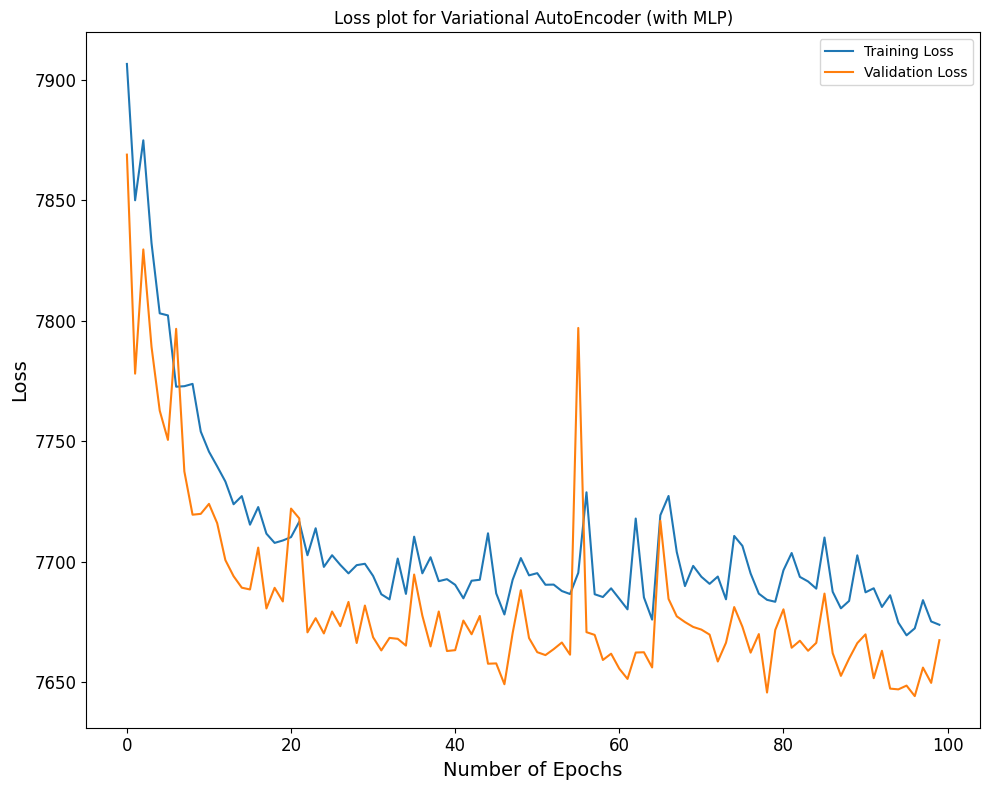

In [21]:
plt.figure(figsize=(10,8))
plt.plot(dense_vae_history.history["loss"])
plt.plot(dense_vae_history.history["val_loss"])
plt.legend(["Training Loss", "Validation Loss"])
plt.title("Loss plot for Variational AutoEncoder (with MLP)")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

In [22]:
# Evaluate the model on the test data
test_loss = dense_vae.evaluate(X_test, X_test)

In [ ]:
loss: 7673.7411 - val_loss: 7667.3369  7692.695394226507

In [23]:
test_loss

7692.695394226507

<BarContainer object of 1 artists>

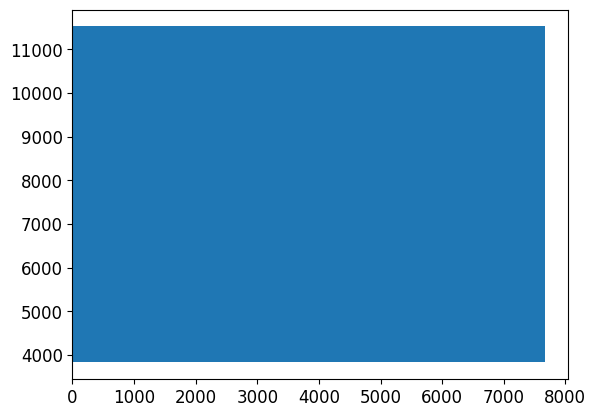

In [27]:
plt.barh(7673.7411, 7667.3369, test_loss)

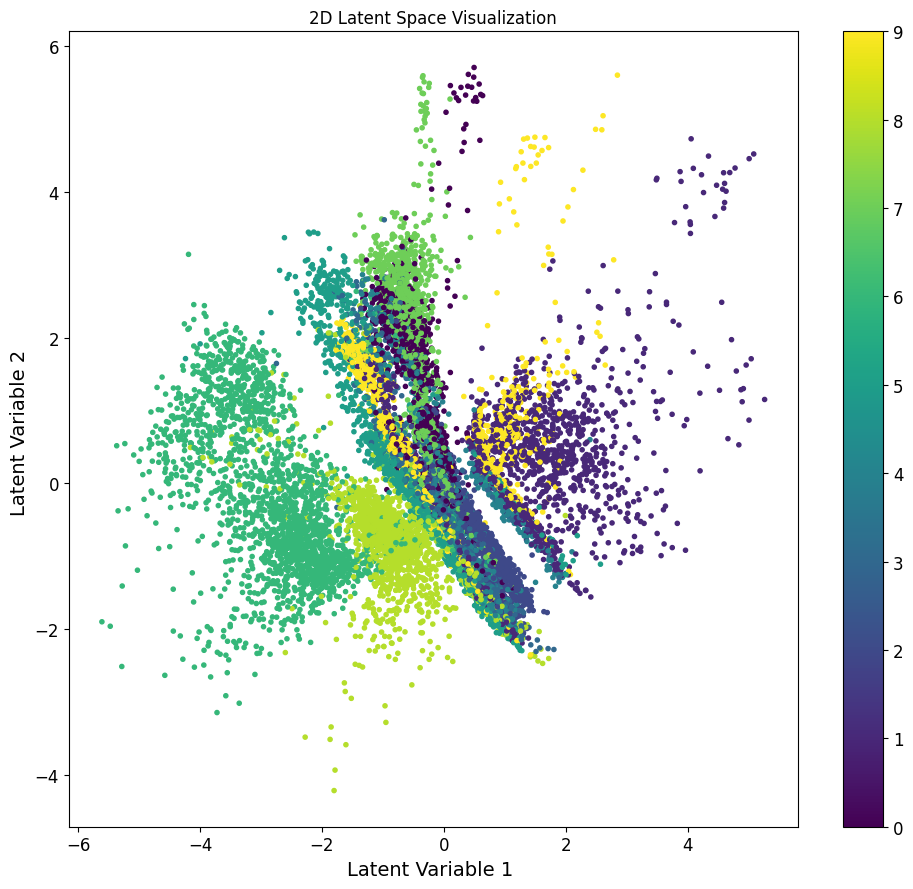

In [46]:
latent_space = encoder.predict(X_train)[0]
y_train = [int(y) for y in y_train]
plt.figure(figsize=(10, 9))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=y_train, s=3**2,cmap='viridis',alpha=1)
plt.colorbar()
plt.xlabel('Latent Variable 1 ')
plt.ylabel('Latent Variable 2 ')
plt.title('2D Latent Space Visualization')
plt.tight_layout()
plt.show()


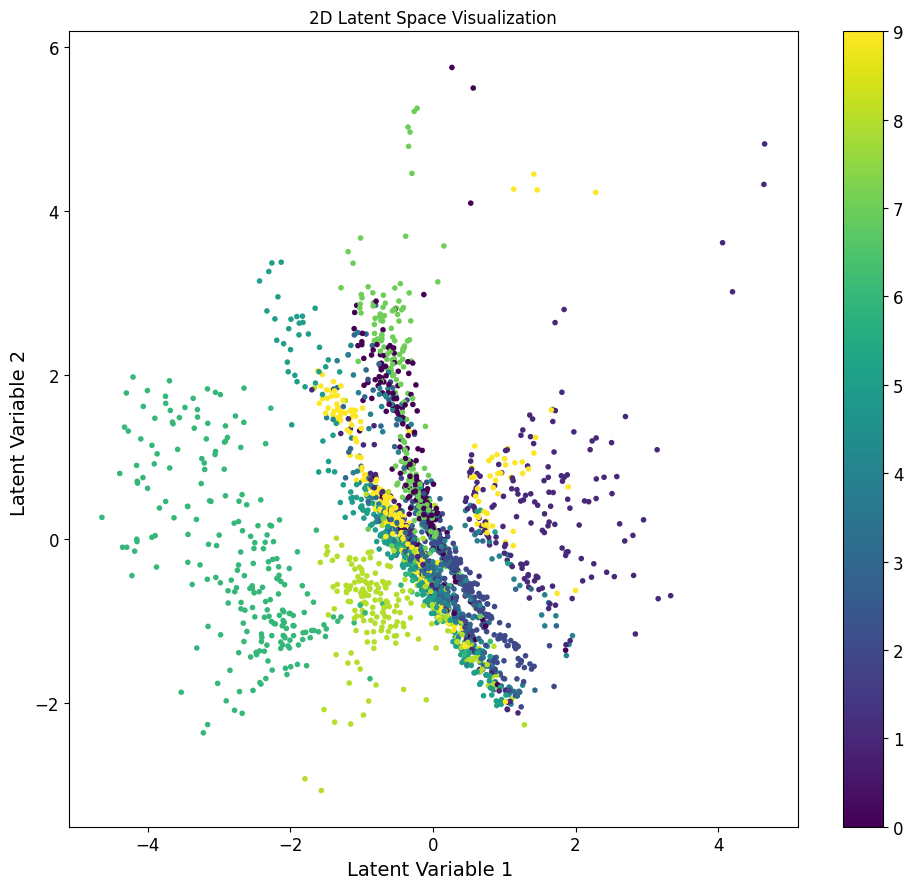

In [45]:
latent_space = encoder.predict(X_val)[0]
y_val = [int(y) for y in y_val]
plt.figure(figsize=(10, 9))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=y_val, s=3**2,cmap='viridis',alpha=1)
plt.colorbar()
plt.xlabel('Latent Variable 1 ')
plt.ylabel('Latent Variable 2 ')
plt.title('2D Latent Space Visualization')
plt.tight_layout()
plt.show()


2023-11-15 14:06:58.386379: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:342 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
22840/22840 [==============================] - 64s 3ms/sample - loss: 9949928.5254 - val_loss: 8427.6236
Epoch 2/100
22840/22840 [==============================] - 62s 3ms/sample - loss: 8685.8543 - val_loss: 8569.1816
Epoch 3/100
22840/22840 [==============================] - 61s 3ms/sample - loss: 8522.9825 - val_loss: 8377.5673
Epoch 4/100
22840/22840 [==============================] - 61s 3ms/sample - loss: 8506.5232 - val_loss: 8205.4903
Epoch 5/100
22840/22840 [==============================] - 61s 3ms/sample - loss: 8261.0748 - val_loss: 8104.8371
Epoch 6/100
22840/22840 [==============================] - 204s 9ms/sample - loss: 12601.6746 - val_loss: 9356.3297
Epoch 7/100
22840/22840 [==============================] - 151s 7ms/sample - loss: 17122.5691 - val_loss: 10473.3295
Epoch 8/100
22840/22840 [==============================] - 95s 4ms/sample - loss: 9971.8597 - val_loss: 9464.1363
Epoch 9/100
22840/22840 [==============================] - 123s 5ms/sample - loss: 9107.4455 - val_loss: 8522.2567
Epoch 10/100
22840/22840 [==============================] - 61s 3ms/sample - loss: 11377.3423 - val_loss: 11114.9137
Epoch 11/100
22840/22840 [==============================] - 62s 3ms/sample - loss: 11209.2646 - val_loss: 10870.3877
Epoch 12/100
22840/22840 [==============================] - 62s 3ms/sample - loss: 10961.6752 - val_loss: 10756.3944
Epoch 13/100
22840/22840 [==============================] - 61s 3ms/sample - loss: 10430.8617 - val_loss: 10006.0978

In [148]:
y_val

array(['0', '5', '5', ..., '2', '5', '3'], dtype='<U1')

In [195]:
# Generate and visualize reconstructed samples

decoded_stft = dense_vae.predict(X_val)
# decoded_stft = MinMaxUnScaler(dense_vae.predict(X_val),X_val_min_max)

In [196]:
len(X_val)

2538

In [197]:
len(decoded_stft)

2538

In [198]:
decoded_stft = decoded_stft.reshape(len(decoded_stft),257,69,1)

In [199]:
decoded_stft.shape

(2538, 257, 69, 1)

In [200]:
def MinMaxUnScaler(features, min_max_values):
    unscaled = []
    for f,min_max in zip(features,min_max_values):
        f = f.reshape(257,69)
        unscaled_feature = (f * (min_max[1] - min_max[0])) + min_max[0]
        unscaled_feature = librosa.db_to_amplitude(unscaled_feature)
        unscaled.append(unscaled_feature)
    return np.array(unscaled)

In [191]:
# def db_to_amplitude():
#     librosa.db_to_amplitude()
#     pass

In [202]:
decoded_stft[0]

array([[3.16883698e-02, 4.91857156e-02, 5.13602719e-02, ...,
        1.00000056e-04, 1.00000056e-04, 1.00000056e-04],
       [3.03837396e-02, 4.92281392e-02, 5.15931584e-02, ...,
        1.00000056e-04, 1.00000056e-04, 1.00000056e-04],
       [2.00502519e-02, 1.42992465e-02, 1.55618479e-02, ...,
        1.00000056e-04, 1.00000056e-04, 1.00000056e-04],
       ...,
       [1.08987966e-04, 9.99999975e-05, 9.99999975e-05, ...,
        9.99999975e-05, 9.99999975e-05, 9.99999975e-05],
       [1.08549204e-04, 9.99999975e-05, 9.99999975e-05, ...,
        9.99999975e-05, 9.99999975e-05, 9.99999975e-05],
       [1.08316875e-04, 9.99999975e-05, 9.99999975e-05, ...,
        9.99999975e-05, 9.99999975e-05, 9.99999975e-05]], dtype=float32)

In [194]:
decoded_stft[0]

array([[-29.982002, -26.16322 , -25.787453, ..., -79.99999 , -79.99999 ,
        -79.99999 ],
       [-30.347176, -26.155731, -25.748158, ..., -79.99999 , -79.99999 ,
        -79.99999 ],
       [-33.957603, -36.893738, -36.158775, ..., -79.99999 , -79.99999 ,
        -79.99999 ],
       ...,
       [-79.252426, -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-79.28747 , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-79.306076, -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

In [201]:
decoded_stft = MinMaxUnScaler(decoded_stft,X_val_min_max)

In [267]:
y_val[1000]

'5'

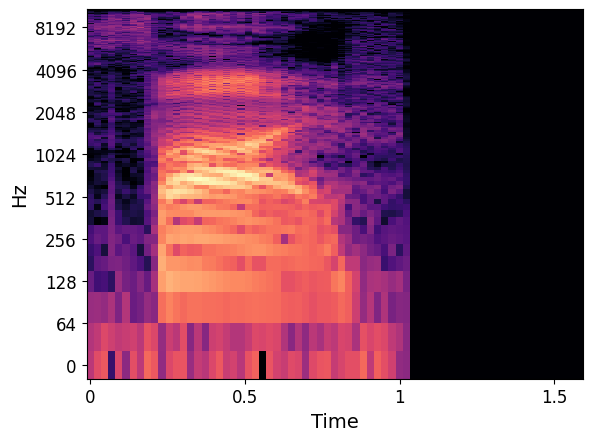

In [203]:
librosa.display.specshow(X_val[1000].reshape(257, 69), x_axis='time', y_axis='log')

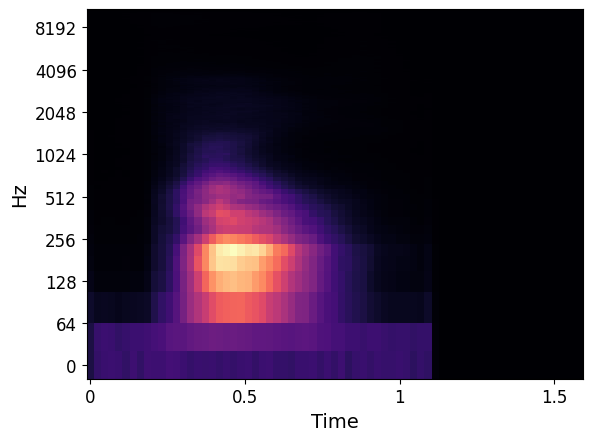

In [208]:
librosa.display.specshow(decoded_stft[1].reshape(257, 69), x_axis='time', y_axis='log')

In [238]:
n = 256#900 #256 #500 #400
abc = librosa.istft(decoded_stft[n],hop_length=256)

## Invserse STFT

In [265]:
def ISTFT(feature):
    audios = []
    for f in tqdm.tqdm(feature,desc="Appling inverse STFT ..."):
        audio = librosa.istft(f,hop_length=256)
        audios.append(audio)
    return np.array(audios)

In [266]:
decoded_istft = ISTFT(decoded_stft)

Appling inverse STFT ...: 100%|██████████| 2538/2538 [00:01<00:00, 1818.40it/s]


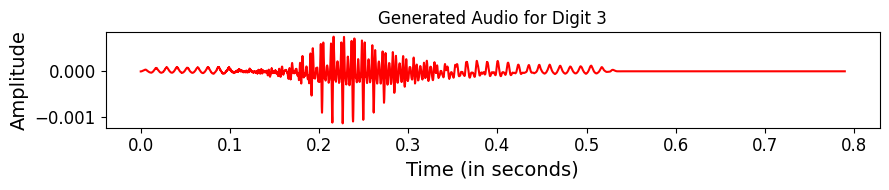

In [268]:
# n = 456 
# n = 900 
# n = 256 
# n = 500 
n = 400

abc = librosa.istft(decoded_stft[n],hop_length=256)

plt.figure(figsize=(9,2))
time_values = np.linspace(0, len(abc)/22050, len(abc))
plt.title("Generated Audio for Digit " + y_val[n])
plt.plot(time_values,abc,color="r")
plt.xlabel("Time (in seconds)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()
Audio(data=abc,rate=22050)

In [240]:
# from IPython.display import Audio

Audio(data=abc,rate=22050)

In [235]:
import soundfile as sf

In [236]:
# sf.output.write_wav("Val_set_900_1.wav", abc, 22050)
sf.write("Val_set_900_1.wav", abc, 22050, format='wav')

In [237]:
dense_vae.save("100_epoch.keras")

NotImplementedError: numpy() is only available when eager execution is enabled.

In [161]:
y_val[0]

'0'

In [167]:
import noisereduce as nr
reduced_noise = nr.reduce_noise(y=abc, sr=22050)

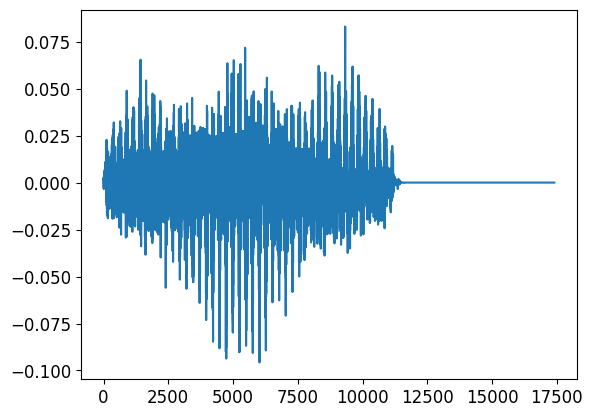

In [168]:
plt.plot(reduced_noise)

In [169]:
from IPython.display import Audio

Audio(data=reduced_noise,rate=22050)

TypeError: 'Axes' object is not subscriptable

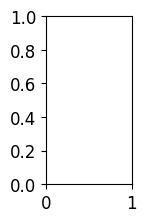

In [121]:

n = 5 # Number of samples to visualize
# plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    librosa.display.specshow(X_val[i].reshape(257, 69), sr=22050, x_axis='time', y_axis='log',ax=ax[2,n, i + 1])
    plt.imshow(X_test[i].reshape(69, 257))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_stft[i].reshape(69, 257))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()


In [48]:
decoded_imgs = dense_vae.predict(X_train[:20])

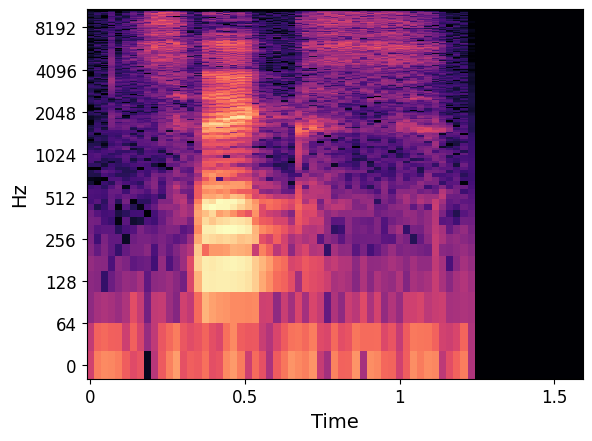

In [54]:
librosa.display.specshow(X_test[5].reshape(257, 69), sr=22050, x_axis='time', y_axis='log')

In [59]:
print(y_test)

[7, 0, 1, 0, 9, 6, 5, 6, 5, 2, 4, 4, 1, 8, 6, 4, 9, 3, 9, 3, 8, 7, 3, 2, 2, 5, 7, 6, 1, 9, 2, 8, 6, 0, 5, 9, 5, 5, 8, 4, 7, 8, 8, 1, 4, 3, 9, 3, 4, 7, 3, 0, 8, 4, 8, 3, 4, 0, 9, 2, 2, 4, 8, 3, 2, 4, 5, 4, 7, 4, 5, 7, 6, 9, 8, 0, 1, 5, 5, 8, 0, 2, 1, 7, 3, 8, 3, 7, 9, 0, 3, 4, 6, 2, 1, 1, 4, 3, 8, 0, 3, 4, 4, 4, 5, 1, 2, 9, 0, 6, 1, 2, 7, 6, 0, 7, 8, 0, 2, 0, 4, 6, 2, 3, 9, 0, 6, 7, 2, 7, 2, 6, 4, 8, 1, 7, 2, 1, 0, 3, 5, 4, 7, 2, 7, 3, 5, 3, 1, 5, 8, 2, 3, 3, 4, 7, 6, 3, 6, 5, 9, 4, 3, 6, 7, 4, 8, 4, 5, 8, 9, 2, 0, 7, 1, 9, 3, 7, 5, 5, 1, 7, 1, 9, 2, 3, 6, 4, 2, 0, 6, 7, 7, 9, 3, 1, 6, 2, 5, 7, 0, 8, 6, 8, 2, 0, 4, 2, 6, 1, 0, 9, 7, 5, 9, 3, 7, 7, 9, 5, 2, 4, 5, 1, 3, 2, 4, 4, 6, 9, 3, 1, 9, 0, 8, 4, 9, 1, 8, 1, 1, 3, 3, 4, 7, 7, 7, 1, 3, 8, 4, 0, 6, 8, 5, 9, 1, 0, 9, 6, 7, 2, 7, 9, 8, 1, 4, 7, 7, 8, 1, 1, 0, 9, 6, 0, 8, 1, 7, 6, 5, 3, 7, 3, 3, 9, 7, 5, 3, 1, 4, 3, 6, 0, 0, 4, 4, 9, 2, 4, 1, 1, 1, 8, 1, 5, 8, 6, 4, 6, 2, 3, 4, 2, 0, 9, 3, 5, 5, 1, 6, 8, 6, 7, 4, 9, 6, 2, 8, 7, 1, 3, 5, 

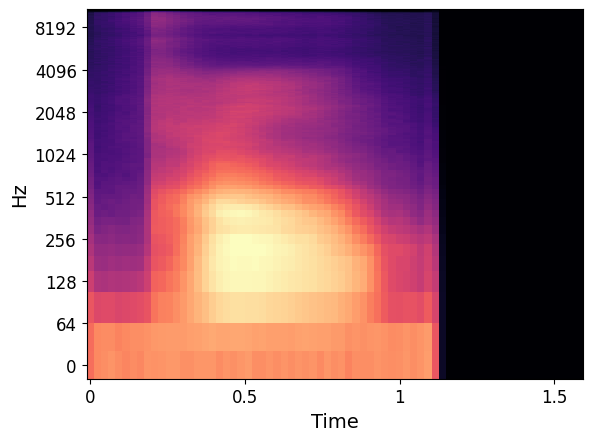

In [55]:
librosa.display.specshow(decoded_imgs[5].reshape(257, 69), sr=22050, x_axis='time', y_axis='log')

In [56]:
abc = librosa.istft(decoded_imgs[5].reshape(257, 69))

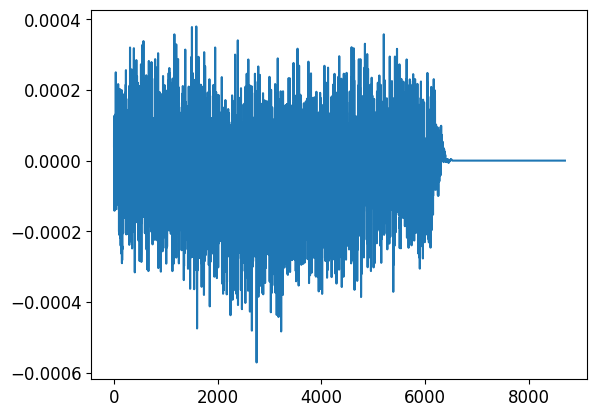

In [57]:
plt.plot(abc)

In [58]:
from IPython.display import Audio

Audio(data=abc,rate=22050)

### Unscale Min Max 

In [60]:
def MinMaxScaler(features):
    scaled = []
    min_max_values = []
    for f in features:
        min_val = np.min(f)
        max_val = np.max(f)
        f_normalized = (f - min_val) / (max_val - min_val)
        min_max_values.append((min_val,max_val))
        scaled.append(f_normalized)
    return np.array(scaled),np.array(min_max_values)

In [61]:
_ , X_train_min_max  = MinMaxScaler(X_train_features)
_ , X_val_min_max = MinMaxScaler(X_val_features)
_ , X_test_min_max = MinMaxScaler(X_test_features)

In [72]:
def MinMaxUnScaler(features, min_max_values):
    unscaled = []
    for f,min_max in zip(features,min_max_values):
        unscaled_feature = (f * (min_max[1] - min_max[0])) + min_max[0]
        unscaled.append(unscaled_feature)
    return np.array(unscaled_feature)

NameError: name 'axs' is not defined

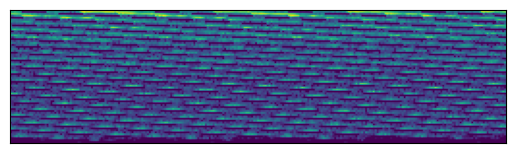

In [64]:
# Generate and visualize reconstructed samples
generated_audio = dense_vae.predict(X_val)
n = 1 # Number of samples to visualize
# plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(69, 257))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    librosa.display.specshow(X_val, sr=22050, x_axis='time', y_axis='log',ax=axs[i, j])
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(69, 257))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()


## VAE with CNN

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

In [ ]:
# Define the Convolutional VAE architecture
input_shape = (1025,81,1)
latent_dim = 2  # Size of the latent space

In [ ]:
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(256,activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    # return the z mean
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
z = Lambda(sampling)([z_mean, z_log_var])

In [ ]:
encoder = Model(inputs, z)
encoder.summary()

In [ ]:
decoder_input = Input(shape=(latent_dim,))
y = Dense(1025 * 81 * 64, activation='relu')(decoder_input)
y = Reshape((1025, 81, 64))(y)
# y = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(y)
y = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(y)
y = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(y)

In [ ]:
decoder_output = y
decoder = Model(decoder_input,y)

decoder.summary()

In [ ]:
outputs = decoder(encoder(inputs))

In [ ]:
# Define the loss function for VAE
def vae_loss(inputs, outputs):
    xent_loss = K.sum(K.binary_crossentropy(inputs, outputs), axis=(1, 2, 3))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [ ]:
cnn_vae = Model(inputs, outputs)
cnn_vae.compile(optimizer='adam', loss=vae_loss)
cnn_vae.summary()

In [ ]:
# Train the VAE
cnn_vae_history = cnn_vae.fit(X_train_features, X_train_features, epochs=2, batch_size=128, shuffle=True, validation_data=(X_val_features, X_val_features))